In [1]:
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import math
from sympy import Symbol, exp, sqrt, pi, Integral
from scipy.integrate import quad
from scipy.special import erf

import torch
import torch.utils.data as data
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda")
# device = torch.device("cpu")

In [2]:
bits_timeslot = 32

In [3]:
m =nn.ReLU()
hidden = 8
class mlp(nn.Module):
    def __init__(self):
        super(mlp, self).__init__()
        self.fc1 = nn.Linear(3,hidden)
        self.fc2 = nn.Linear(hidden,hidden)
        self.fc3 = nn.Linear(hidden,hidden)
#         self.fc4 = nn.Linear(hidden,hidden)
#         self.fc5 = nn.Linear(hidden,hidden)
#         self.fc6 = nn.Linear(hidden,hidden)
        self.fc7 = nn.Linear(hidden,1)
    def forward(self, x):
        x = x.float()
        x = m(self.fc1(x))
        x = m(self.fc2(x))
        x = m(self.fc3(x))
#         x = m(self.fc4(x))
#         x = m(self.fc5(x))
#         x = m(self.fc6(x))
        x = m(self.fc7(x))
        return x


In [4]:
# CPU Version

# loading_model = "./output/model_20210719.pth"
# model = mlp()
# model.load_state_dict(torch.load(loading_model, map_location=device))
# loss_fn = nn.MSELoss()
# model=mlp().to(device)

In [5]:
#GPU Version
model=mlp().to(device)

loading_model = "./output/model_20221121_3881.pth"
model = torch.load(loading_model)
loss_fn = nn.MSELoss()

In [6]:
def theory_bpsk(tx_snr, H):
    return 0.5*math.erfc(0.5*H*np.sqrt(tx_snr))
#     return 0.5*math.erfc(H*np.sqrt(tx_snr))

def theory_f(tx_snr, H_f, p_n):
    return 0.25*(math.erfc(H_f*np.sqrt(tx_snr))+math.erfc((1-p_n-0.5)*H_f*np.sqrt(tx_snr)))
#     return 0.25*(math.erfc(0.5*H_f*np.sqrt(tx_snr))+math.erfc((1-p_n-0.5)*H_f*np.sqrt(tx_snr)))

def theory_n(tx_snr, H_n, p_n):
    return 0.5*math.erfc(p_n*H_n*np.sqrt(tx_snr))
#     return 0.5*math.erfc(p_n*H_n/2*np.sqrt(tx_snr))

def theory_n_ip(tx_snr, H_n, p_n):
    x= Symbol('x')
    f = 1/sqrt(pi)*exp(-x**2)
    result = Integral(f,(x,H_n*(2*(1-p_n)- p_n)/2*sqrt(tx_snr),math.inf)) + Integral(f, (x, H_n*(p_n-2)/2*sqrt(tx_snr), -1/2*sqrt(tx_snr)*H_n))
    result = result.doit().evalf()/2
    result = (1-theory_f(tx_snr, H_n, p_n))*theory_n(tx_snr, H_n, p_n) + (theory_f(tx_snr, H_n, p_n) - result)
    return result

In [7]:
def f_channel(x,y,z):
    led_x = 5
    led_y = 5
    led_z = 2.5
    theta = 60
    m=-np.log10(2)/np.log10(np.cos(np.deg2rad(theta)))
    p_total = 60
    Adet=1e-4
    Ts=1
    index=1.5
    FOV=60
    
    # distance between led and pd
    d= np.sqrt(np.power(led_x-x,2)+np.power(led_y-y,2))
    
    # angle between led and pd
    theta_T = np.arctan(d/(led_z-z))
    theta_R = theta_T
    # Transmitted signal power
    m1= -np.log10(2)/np.log10(np.cos(np.rad2deg(theta)))
    T_S = p_total *(m1+1)/(2*np.pi)*(np.cos(theta_T))
    
    # Received signal power to pd
    Aeff= Adet*np.cos(theta_R)
    G_conv = index*index/np.sin(np.deg2rad(FOV))
    d2 = np.sqrt(np.power(d,2)+np.power(led_z-z,2))
    H_los = Aeff*T_S*G_conv/(d2*d2)
    if (FOV >= np.rad2deg(theta_R)):
        return H_los*p_total
    else:
        return 0

In [8]:
class node:
    def __init__(self, x, y, z, released_time, computing_time, deadline, period):
        if period == 250:
            self.h=100
        else:
            self.h = f_channel(x,y,z)
        self.r_t = released_time
        self.p = period
        self.dl = deadline
        self.ct = computing_time
        self.bits = computing_time * bits_timeslot / 10 #1 timeslots takes 10 ms. That's why 10 is used for the division.
    def check(self, current_time):
        if ((current_time - self.r_t)%self.p) == 0:
            return [self.h, current_time, self.dl+current_time, self.ct, self.bits]

In [9]:
class OMA_DMS_scheduling:
    def __init__(self, tx_snr):
        self.table = []
        self.tx_snr = tx_snr
    
    def insert(self, data): #h=data[0], released_time=data[1], deadline=data[2], computing_time=data[3], bits_length = data[4]
        self.table.append(data.copy())
    
    def show_table(self):
        return self.table
        
    def check_deadlines(self, current_time):
        missed_deadline = 0
        i = 0 
        while i < len(self.table):
            if(current_time > self.table[i][2]):
                missed_deadline += 1
                del self.table[i]
                i = 0
            else:
                i+=1
        return missed_deadline
    
    def scheduling(self):
        self.table.sort(key=lambda x:x[2]) #Based on Deadlines, the scheduling orders are decided.
    
    def transmission(self):
        PE = 0
        if len(self.table) != 0:
            self.table[0][3] = self.table[0][3] - 10
            if self.table[0][3] <= 0:
                PE = self.check_err(self.table[0][4])
#                 self.show_ber()
                del self.table[0]
        return PE #Packet Error
    
    def check_err(self, bits_len):
        ber = theory_bpsk(self.tx_snr, self.table[0][0])
        self.ber = ber
        per = 1-(1-ber)**bits_len
#         print(ber, per)
        if(np.random.rand(1)<= per):
            return 1
        else:
            return 0
        
    def run(self, current_time):
        missed_deadline = self.check_deadlines(current_time)
#         print('DMS DMS', self.table)
        self.scheduling()
        packet_error = self.transmission()
        return missed_deadline, packet_error
    
    def show_ber(self):
        print(self.ber)

In [10]:
class NOMA_DMS_scheduling:
    def __init__(self, tx_snr):
        self.table = []
        self.tx_snr = tx_snr
    
    def insert(self, data): #h=data[0], released_time=data[1], deadline=data[2], computing_time=data[3], bits_length = data[4]
        self.table.append(data.copy())
    
    def show_table(self):
        return self.table
        
    def check_deadlines(self, current_time):
        missed_deadline = 0
        i = 0 
        while i < len(self.table):
            if(current_time > self.table[i][2]):
                missed_deadline += 1
#                 print('not DNN: ', self.table[i])
                del self.table[i]
                i = 0
            else:
                i+=1
        return missed_deadline
    
    def scheduling(self):
        self.table.sort(key=lambda x:x[2]) #Based on Deadlines, the scheduling orders are decided.    
        if len(self.table) > 1:
            temp = []
            for i in range(len(self.table)):
                temp.append(np.abs(self.table[i][0] - self.table[0][0]))
            ind = np.argmax(temp)
            self.table[ind], self.table[1] = self.table[1], self.table[ind]
    
    def transmission(self):
        PE1 = 0
        PE2 = 0 
        tab_len = len(self.table)
        
        if tab_len == 1:
            self.check_err()
            self.table[0][3] = self.table[0][3] - 10
            if self.table[0][3] <= 0:
                if self.table[0][1] == -1:
                    PE1 = 1
                del self.table[0]
        elif tab_len > 1:
            p_n = 0.2  ##### Here is the part for power allocation to be added.
            self.check_err_nf(p_n)
            del_U0 = 0
            del_U1 = 0
            self.table[0][3] = self.table[0][3] - 10
            self.table[1][3] = self.table[1][3] - 10
            
            if self.table[0][3] <= 0:
                if self.table[0][1] == -1:
                    PE1 = 1
                del_U0 = 1
            if self.table[1][3] <= 0:
                if self.table[0][1] == -1:
                    PE2 = 1
                del_U1 = 1
                
            if del_U1 == 1:
                del self.table[1]
            if del_U0 == 1:
                del self.table[0]
                
        return PE1, PE2 #Packet Error
    
    def check_err(self): # If there is a PE, the relased_time will be -1
        ber = theory_bpsk(self.tx_snr, self.table[0][0])
        per = 1-(1-ber)**bits_timeslot
        
#         print(ber, per)
        if(np.random.rand(1)<= per):
            self.table[0][1] = -1
    
    def check_err_nf(self, p_n):
        if self.table[0][0] >= self.table[1][0]:
            ber_f = theory_f(self.tx_snr, self.table[0][0], p_n)
            ber_n = theory_n(self.tx_snr, self.table[1][0], p_n)
            
            per_0 = 1-(1-ber_f)**bits_timeslot
            per_1 = 1-(1-ber_n)**bits_timeslot
        else:
            ber_n = theory_n(self.tx_snr, self.table[0][0], p_n)
            ber_f = theory_f(self.tx_snr, self.table[1][0], p_n)
            
            per_0 = 1-(1-ber_n)**bits_timeslot
            per_1 = 1-(1-ber_f)**bits_timeslot

#         print(ber_f, ber_n)
        if(np.random.rand(1)<= per_0):
            self.table[0][1] = -1
        if(np.random.rand(1)<= per_1):
            self.table[1][1] = -1
 
        
    def run(self, current_time):
        missed_deadline = self.check_deadlines(current_time)
#         print('not DNN', self.table)
        self.scheduling()
        packet_error1, packet_error2 = self.transmission()
        packet_error = packet_error1+ packet_error2
        return missed_deadline, packet_error

In [11]:
class NOMA_DMS_scheduling_DNN_power:
    def __init__(self, tx_snr):
        self.table = []
        self.tx_snr = tx_snr
    
    def insert(self, data): #h=data[0], released_time=data[1], deadline=data[2], computing_time=data[3], bits_length = data[4]
        self.table.append(data.copy())
    
    def show_table(self):
        return self.table
        
    def check_deadlines(self, current_time):
        missed_deadline = 0
        i = 0 
        while i < len(self.table):
            if(current_time > self.table[i][2]):
                missed_deadline += 1
#                 print('DNN: ', self.table[i])
                del self.table[i]
                i = 0
            else:
                i+=1
        return missed_deadline
    
    def scheduling(self):
        self.table.sort(key=lambda x:x[2]) #Based on Deadlines, the scheduling orders are decided.    
        if len(self.table) > 1:
            temp = []
            for i in range(len(self.table)):
                temp.append(np.abs(self.table[i][0] - self.table[0][0]))
            ind = np.argmax(temp)
            self.table[ind], self.table[1] = self.table[1], self.table[ind]
    
    def transmission(self):
        PE1 = 0
        PE2 = 0 
        tab_len = len(self.table)
        
        if tab_len == 1:
            self.check_err()
            self.table[0][3] = self.table[0][3] - 10
            if self.table[0][3] <= 0:
                if self.table[0][1] == -1:
                    PE1 = 1
                del self.table[0]
        elif tab_len > 1:
#             p_n = 0.2  ##### Here is the part for power allocation to be added.
            self.check_err_nf()
            del_U0 = 0
            del_U1 = 0
            self.table[0][3] = self.table[0][3] - 10
            self.table[1][3] = self.table[1][3] - 10
            
            if self.table[0][3] <= 0:
                if self.table[0][1] == -1:
                    PE1 = 1
                del_U0 = 1
            if self.table[1][3] <= 0:
                if self.table[0][1] == -1:
                    PE2 = 1
                del_U1 = 1
                
            if del_U1 == 1:
                del self.table[1]
            if del_U0 == 1:
                del self.table[0]
                
        return PE1, PE2 #Packet Error
    
    def check_err(self): # If there is a PE, the relased_time will be -1
        ber = theory_bpsk(self.tx_snr, self.table[0][0])
        per = 1-(1-ber)**bits_timeslot
#         print(ber, per)
        if(np.random.rand(1)<= per):
            self.table[0][1] = -1
    
    def check_err_nf(self):
        if self.table[0][0] >= self.table[1][0]:
            NU_h = self.table[0][0]
            FU_h = self.table[1][0]
        else:
            NU_h = self.table[1][0]
            FU_h = self.table[0][0]
            
        snr = 10*np.log10(self.tx_snr)
        xx = [[snr, NU_h, FU_h]]
        xx = torch.tensor(np.array(list(np.float_(xx)))).to(device)

        model.eval()
        with torch.no_grad():
            output = model(xx).squeeze() #Different dimension may cause wrong results of backpropagation(Something called broadcasting)
        p_n = output/100
        ber_f = theory_f(self.tx_snr, self.table[0][0], p_n)
        ber_n = theory_n(self.tx_snr, self.table[1][0], p_n)

        per_0 = 1-(1-ber_f)**bits_timeslot
        per_1 = 1-(1-ber_n)**bits_timeslot
            
        if(np.random.rand(1)<= per_0):
            self.table[0][1] = -1
        if(np.random.rand(1)<= per_1):
            self.table[1][1] = -1
#         print(output, p_n, NU_h, ber_n)
#         print(ber_f, ber_n)
    def run(self, current_time):
        missed_deadline = self.check_deadlines(current_time)
#         print('DNN DNN', self.table)
#         print()
        self.scheduling()
        packet_error1, packet_error2 = self.transmission()
        packet_error = packet_error1+ packet_error2
        return missed_deadline, packet_error

In [12]:
def FTPC(tx_snr, H_f, H_n, a):
    N0 = 1/np.log10(tx_snr)
    p_f = 1/((H_f/N0+H_n/N0)**(-a))*(H_f/N0)**(-a)
    p_n = 1/((H_f/N0+H_n/N0)**(-a))*(H_n/N0)**(-a)
    p_n = p_n/(p_f+p_n)
    return p_n

class NOMA_DMS_scheduling_FTPC_power:
    def __init__(self, tx_snr):
        self.table = []
        self.tx_snr = tx_snr
    
    def insert(self, data): #h=data[0], released_time=data[1], deadline=data[2], computing_time=data[3], bits_length = data[4]
        self.table.append(data.copy())
    
    def show_table(self):
        return self.table
        
    def check_deadlines(self, current_time):
        missed_deadline = 0
        i = 0 
        while i < len(self.table):
            if(current_time > self.table[i][2]):
                missed_deadline += 1
#                 print('DNN: ', self.table[i])
                del self.table[i]
                i = 0
            else:
                i+=1
        return missed_deadline
    
    def scheduling(self):
        self.table.sort(key=lambda x:x[2]) #Based on Deadlines, the scheduling orders are decided.    
        if len(self.table) > 1:
            temp = []
            for i in range(len(self.table)):
                temp.append(np.abs(self.table[i][0] - self.table[0][0]))
            ind = np.argmax(temp)
            self.table[ind], self.table[1] = self.table[1], self.table[ind]
    
    def transmission(self):
        PE1 = 0
        PE2 = 0 
        tab_len = len(self.table)
        
        if tab_len == 1:
            self.check_err()
            self.table[0][3] = self.table[0][3] - 10
            if self.table[0][3] <= 0:
                if self.table[0][1] == -1:
                    PE1 = 1
                del self.table[0]
        elif tab_len > 1:
#             p_n = 0.2  ##### Here is the part for power allocation to be added.
            self.check_err_nf()
            del_U0 = 0
            del_U1 = 0
            self.table[0][3] = self.table[0][3] - 10
            self.table[1][3] = self.table[1][3] - 10
            
            if self.table[0][3] <= 0:
                if self.table[0][1] == -1:
                    PE1 = 1
                del_U0 = 1
            if self.table[1][3] <= 0:
                if self.table[0][1] == -1:
                    PE2 = 1
                del_U1 = 1
                
            if del_U1 == 1:
                del self.table[1]
            if del_U0 == 1:
                del self.table[0]
                
        return PE1, PE2 #Packet Error
    
    def check_err(self): # If there is a PE, the relased_time will be -1
        ber = theory_bpsk(self.tx_snr, self.table[0][0])
        per = 1-(1-ber)**bits_timeslot
#         print(ber, per)
        if(np.random.rand(1)<= per):
            self.table[0][1] = -1
    
    def check_err_nf(self):
        if self.table[0][0] >= self.table[1][0]:
            NU_h = self.table[0][0]
            FU_h = self.table[1][0]
        else:
            NU_h = self.table[1][0]
            FU_h = self.table[0][0]
            
        p_n = FTPC(self.tx_snr, FU_h, NU_h, a=0.4)

        ber_f = theory_f(self.tx_snr, self.table[0][0], p_n)
        ber_n = theory_n(self.tx_snr, self.table[1][0], p_n)

        per_0 = 1-(1-ber_f)**bits_timeslot
        per_1 = 1-(1-ber_n)**bits_timeslot
            
        if(np.random.rand(1)<= per_0):
            self.table[0][1] = -1
        if(np.random.rand(1)<= per_1):
            self.table[1][1] = -1
#         print(output, p_n, NU_h, ber_n)
#         print(ber_f, ber_n)
    def run(self, current_time):
        missed_deadline = self.check_deadlines(current_time)
#         print('DNN DNN', self.table)
#         print()
        self.scheduling()
        packet_error1, packet_error2 = self.transmission()
        packet_error = packet_error1+ packet_error2
        return missed_deadline, packet_error

In [13]:
def qfunc(x):
    return 0.5-0.5*erf(x/np.sqrt(2))
def C(x):
    return np.log2(1+x)
def V(x):
    return (1-1/((1+x)**2))*np.log2(np.exp(1))**2
def n(x):
    t = 128
    err= 1e-5
    qe=qfunc(err)
    return np.sqrt((4*C(x)*qe**2*t+V(x)) + np.sqrt(V(x)))/(2*C(x)*qe)**2
def FBL(tx_snr, H_f, H_n):
    p_n =[]
    for i in range(1, 500):
        p_n.append(i/1000)
    N0 = 1/np.log10(tx_snr)
    t = np.zeros(500)
    for i in range(1,500):
        j = i-1
        sinr_n = (p_n[j]*H_n**2)/N0
        sinr_f = ((1-p_n[j])*H_f**2)/(p_n[j]*H_f**2+N0)
        
        #print(sinr_n, sinr_f)
        t[j]=n(sinr_n) + n(sinr_f)
    return p_n[np.argmin(t[0:499])]

class NOMA_DMS_scheduling_FBL_power:
    def __init__(self, tx_snr):
        self.table = []
        self.tx_snr = tx_snr
    
    def insert(self, data): #h=data[0], released_time=data[1], deadline=data[2], computing_time=data[3], bits_length = data[4]
        self.table.append(data.copy())
    
    def show_table(self):
        return self.table
        
    def check_deadlines(self, current_time):
        missed_deadline = 0
        i = 0 
        while i < len(self.table):
            if(current_time > self.table[i][2]):
                missed_deadline += 1
#                 print('DNN: ', self.table[i])
                del self.table[i]
                i = 0
            else:
                i+=1
        return missed_deadline
    
    def scheduling(self):
        self.table.sort(key=lambda x:x[2]) #Based on Deadlines, the scheduling orders are decided.    
        if len(self.table) > 1:
            temp = []
            for i in range(len(self.table)):
                temp.append(np.abs(self.table[i][0] - self.table[0][0]))
            ind = np.argmax(temp)
            self.table[ind], self.table[1] = self.table[1], self.table[ind]
    
    def transmission(self):
        PE1 = 0
        PE2 = 0 
        tab_len = len(self.table)
        
        if tab_len == 1:
            self.check_err()
            self.table[0][3] = self.table[0][3] - 10
            if self.table[0][3] <= 0:
                if self.table[0][1] == -1:
                    PE1 = 1
                del self.table[0]
        elif tab_len > 1:
#             p_n = 0.2  ##### Here is the part for power allocation to be added.
            self.check_err_nf()
            del_U0 = 0
            del_U1 = 0
            self.table[0][3] = self.table[0][3] - 10
            self.table[1][3] = self.table[1][3] - 10
            
            if self.table[0][3] <= 0:
                if self.table[0][1] == -1:
                    PE1 = 1
                del_U0 = 1
            if self.table[1][3] <= 0:
                if self.table[0][1] == -1:
                    PE2 = 1
                del_U1 = 1
                
            if del_U1 == 1:
                del self.table[1]
            if del_U0 == 1:
                del self.table[0]
                
        return PE1, PE2 #Packet Error
    
    def check_err(self): # If there is a PE, the relased_time will be -1
        ber = theory_bpsk(self.tx_snr, self.table[0][0])
        per = 1-(1-ber)**bits_timeslot
#         print(ber, per)
        if(np.random.rand(1)<= per):
            self.table[0][1] = -1
    
    def check_err_nf(self):
        if self.table[0][0] >= self.table[1][0]:
            NU_h = self.table[0][0]
            FU_h = self.table[1][0]
        else:
            NU_h = self.table[1][0]
            FU_h = self.table[0][0]
            
        p_n = FBL(self.tx_snr, FU_h, NU_h)
        ber_f = theory_f(self.tx_snr, self.table[0][0], p_n)
        ber_n = theory_n(self.tx_snr, self.table[1][0], p_n)

        per_0 = 1-(1-ber_f)**bits_timeslot
        per_1 = 1-(1-ber_n)**bits_timeslot
            
        if(np.random.rand(1)<= per_0):
            self.table[0][1] = -1
        if(np.random.rand(1)<= per_1):
            self.table[1][1] = -1
#         print(output, p_n, NU_h, ber_n)
#         print(ber_f, ber_n)
    def run(self, current_time):
        missed_deadline = self.check_deadlines(current_time)
#         print('DNN DNN', self.table)
#         print()
        self.scheduling()
        packet_error1, packet_error2 = self.transmission()
        packet_error = packet_error1+ packet_error2
        return missed_deadline, packet_error

In [14]:
def larger_than_input(inp):
    return np.random.randint(inp/10, 10)*10

def PR_larger_than_input(inp):
    return np.random.randint(inp/10, 10)*20

In [15]:
num_of_nodes = 10

nodes_info = []
# nodes_info.append(node(5.0, 5.0, 1.5, 0, 10, 10, 250)) #x, y, z, releaesd_time, computing_time, deadline, period

for i in range(num_of_nodes):
    x = np.random.randint(400,600)/100
    y = np.random.randint(400,600)/100
    z = 1.5
    r_t = i*10
    c_t = np.random.randint(1,5)*10
    dl = larger_than_input(c_t)
    p = PR_larger_than_input(dl) #periods
    nodes_info.append(node(x, y, z, r_t, c_t, dl, p))

In [16]:
# for i in range(1000):
#     for j in range(len(nodes_info)):
#         if nodes_info[j].check(i) != None:
#             print(nodes_info[j].check(i))

In [17]:
snr = 60
time = 100000
interval = 10
snr_interval = 5

DMS_MD_ary = []
DMS_PE_ary = []
DMS_success_rate_ary = []

NOMA_DMS_MD_ary = []
NOMA_DMS_PE_ary = []
NOMA_DMS_success_rate_ary = []

NOMA_DNN_DMS_MD_ary = []
NOMA_DNN_DMS_PE_ary = []
NOMA_DNN_DMS_success_rate_ary = []


NOMA_FTPC_DMS_MD_ary = []
NOMA_FTPC_DMS_PE_ary = []
NOMA_FTPC_DMS_success_rate_ary = []

NOMA_FBL_DMS_MD_ary = []
NOMA_FBL_DMS_PE_ary = []
NOMA_FBL_DMS_success_rate_ary = []

TX_snr=[]
for EbN0 in range(1,snr):
    #print([EbN0, H_f, H_n])
    TX_snr.append(math.pow(10,(EbN0/10)))
    
for tx_snr in TX_snr[30:snr]:
    transmit_count = 0
    OMA_DMS = OMA_DMS_scheduling(tx_snr)
    NOMA_DMS = NOMA_DMS_scheduling(tx_snr)
    NOMA_DNN_DMS = NOMA_DMS_scheduling_DNN_power(tx_snr)
    
    NOMA_FTPC_DMS = NOMA_DMS_scheduling_FTPC_power(tx_snr)
    NOMA_FBL_DMS = NOMA_DMS_scheduling_FBL_power(tx_snr)
       
    DMS_MD = 0
    DMS_PE = 0

    NOMA_DMS_MD = 0
    NOMA_DMS_PE = 0

    NOMA_DNN_DMS_MD = 0
    NOMA_DNN_DMS_PE = 0
    
    NOMA_FTPC_DMS_MD = 0
    NOMA_FTPC_DMS_PE = 0
    
    NOMA_FBL_DMS_MD = 0
    NOMA_FBL_DMS_PE = 0
    for i in range(0, time, interval):
        for j in range(len(nodes_info)):
            temp = nodes_info[j].check(i)
            if(temp != None):
                transmit_count += 1
#                 print(i,temp) #################################
                OMA_DMS.insert(temp)
                NOMA_DMS.insert(temp)
                NOMA_DNN_DMS.insert(temp)
                NOMA_FTPC_DMS.insert(temp)
                NOMA_FBL_DMS.insert(temp)
        temp1, temp2 = OMA_DMS.run(i)
        temp3, temp4 = NOMA_DMS.run(i)
        temp5, temp6 = NOMA_DNN_DMS.run(i)
        
        temp7, temp8 = NOMA_FTPC_DMS.run(i)
        temp9, temp10 = NOMA_FBL_DMS.run(i)

        DMS_MD = DMS_MD + temp1
        DMS_PE = DMS_PE + temp2
        NOMA_DMS_MD = NOMA_DMS_MD + temp3
        NOMA_DMS_PE = NOMA_DMS_PE + temp4
        NOMA_DNN_DMS_MD = NOMA_DNN_DMS_MD + temp5
        NOMA_DNN_DMS_PE = NOMA_DNN_DMS_PE + temp6
        NOMA_FTPC_DMS_MD = NOMA_FTPC_DMS_MD + temp7
        NOMA_FTPC_DMS_PE = NOMA_FTPC_DMS_PE + temp8
        NOMA_FBL_DMS_MD = NOMA_FBL_DMS_MD + temp9
        NOMA_FBL_DMS_PE = NOMA_FBL_DMS_PE + temp10
    
    gura = 0
    DMS_MD_ary.append(DMS_MD)
    DMS_PE_ary.append(DMS_PE)
    DMS_success_rate_ary.append(1-(DMS_MD+DMS_PE)/(transmit_count+gura))

    NOMA_DMS_MD_ary.append(NOMA_DMS_MD)
    NOMA_DMS_PE_ary.append(NOMA_DMS_PE)
    NOMA_DMS_success_rate_ary.append(1-(NOMA_DMS_MD+NOMA_DMS_PE)/(transmit_count+gura))

    NOMA_DNN_DMS_MD_ary.append(NOMA_DNN_DMS_MD)
    NOMA_DNN_DMS_PE_ary.append(NOMA_DNN_DMS_PE)
    NOMA_DNN_DMS_success_rate_ary.append(1-(NOMA_DNN_DMS_MD+NOMA_DNN_DMS_PE)/(transmit_count+gura))
    
    NOMA_FTPC_DMS_MD_ary.append(NOMA_FTPC_DMS_MD)
    NOMA_FTPC_DMS_PE_ary.append(NOMA_FTPC_DMS_PE)
    NOMA_FTPC_DMS_success_rate_ary.append(1-(NOMA_FTPC_DMS_MD+NOMA_FTPC_DMS_PE)/(transmit_count+gura))
    
    NOMA_FBL_DMS_MD_ary.append(NOMA_FBL_DMS_MD)
    NOMA_FBL_DMS_PE_ary.append(NOMA_FBL_DMS_PE)
    NOMA_FBL_DMS_success_rate_ary.append(1-(NOMA_FBL_DMS_MD+NOMA_FBL_DMS_PE)/(transmit_count+gura))
    
    
#     print('transmit_count: ', transmit_count+gura)
#     print('tx_snr: ', tx_snr)
#     print('OMA: ', DMS_MD, DMS_PE, DMS_MD+DMS_PE, 1-(DMS_MD+DMS_PE)/(transmit_count+gura))
#     print('NOMA: ', NOMA_DMS_MD, NOMA_DMS_PE-100, NOMA_DMS_MD + NOMA_DMS_PE - 100, 1-(NOMA_DMS_MD + NOMA_DMS_PE - 100)/(transmit_count+gura))
#     print('NOMA_DNN: ', NOMA_DNN_DMS_MD, NOMA_DNN_DMS_PE-200, NOMA_DNN_DMS_MD + NOMA_DNN_DMS_PE-200, 1-(NOMA_DNN_DMS_MD + NOMA_DNN_DMS_PE-200)/(transmit_count+gura))
#     print()

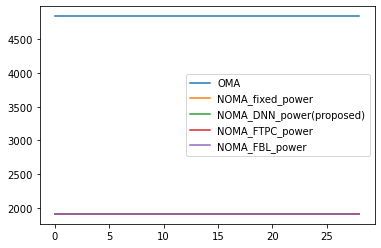

In [18]:
plt.plot(DMS_MD_ary, label ='OMA')
plt.plot(NOMA_DMS_MD_ary, label ='NOMA_fixed_power')
plt.plot(NOMA_DNN_DMS_MD_ary, label ='NOMA_DNN_power(proposed)')
plt.plot(NOMA_FTPC_DMS_MD_ary, label ='NOMA_FTPC_power')
plt.plot(NOMA_FBL_DMS_MD_ary, label ='NOMA_FBL_power')
plt.legend()
plt.show()

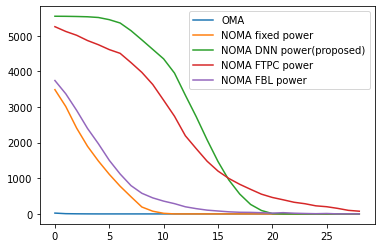

In [20]:
plt.plot(DMS_PE_ary, label ='OMA')
plt.plot(NOMA_DMS_PE_ary, label ='NOMA fixed power')
plt.plot(NOMA_DNN_DMS_PE_ary, label ='NOMA DNN power(proposed)')
plt.plot(NOMA_FTPC_DMS_PE_ary, label ='NOMA FTPC power')
plt.plot(NOMA_FBL_DMS_PE_ary, label ='NOMA FBL power')
plt.legend()
plt.show()

In [34]:
NOMA_FBL_DMS_PE_ary

[3743,
 3370,
 2905,
 2398,
 1969,
 1504,
 1120,
 794,
 579,
 450,
 359,
 288,
 200,
 148,
 106,
 82,
 59,
 46,
 43,
 34,
 22,
 35,
 20,
 12,
 6,
 12,
 1,
 2,
 0]

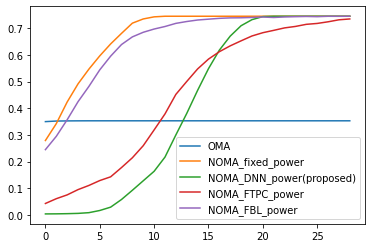

In [22]:
plt.plot(DMS_success_rate_ary, label ='OMA')
plt.plot(NOMA_DMS_success_rate_ary, label ='NOMA_fixed_power')
plt.plot(NOMA_DNN_DMS_success_rate_ary, label ='NOMA_DNN_power(proposed)')
plt.plot(NOMA_FTPC_DMS_success_rate_ary, label ='NOMA_FTPC_power')
plt.plot(NOMA_FBL_DMS_success_rate_ary, label ='NOMA_FBL_power')
plt.legend()
plt.show()

In [39]:
NOMA_FBL_DMS_success_rate_ary

[0.2449579270735942,
 0.29477761453185525,
 0.3568852677975157,
 0.4246026445839455,
 0.4819019634032322,
 0.5440096166688928,
 0.5952985174302123,
 0.638840657139041,
 0.6675570989715507,
 0.6847869640710564,
 0.6969413650327234,
 0.7064244690797382,
 0.7181781755042074,
 0.7251235474823027,
 0.7307332710030721,
 0.7339388273006544,
 0.7370108187525044,
 0.7387471617470283,
 0.739147856284226,
 0.7403499398958194,
 0.7419527180446106,
 0.7402163750500868,
 0.7422198477360759,
 0.7432883665019367,
 0.7440897555763324,
 0.7432883665019367,
 0.7447575798049954,
 0.7446240149592627,
 0.7448911446507279]

In [24]:
NOMA_DMS_success_rate_ary

[0.2791505275811407,
 0.34232669961266193,
 0.4234005609723521,
 0.4913850674502471,
 0.5466809135835449,
 0.5963670361960731,
 0.6411112595164953,
 0.6806464538533459,
 0.7189795645786029,
 0.73474021637505,
 0.7426205422732737,
 0.7448911446507279,
 0.7448911446507279,
 0.7448911446507279,
 0.7448911446507279,
 0.7448911446507279,
 0.7448911446507279,
 0.7448911446507279,
 0.7448911446507279,
 0.7448911446507279,
 0.7448911446507279,
 0.7448911446507279,
 0.7448911446507279,
 0.7448911446507279,
 0.7448911446507279,
 0.7448911446507279,
 0.7448911446507279,
 0.7448911446507279,
 0.7448911446507279]

In [25]:
NOMA_FTPC_DMS_success_rate_ary

[0.04314144517163088,
 0.061039134499799697,
 0.07533057299318824,
 0.09509817016161348,
 0.11072525711232806,
 0.1290236409776947,
 0.143047949779618,
 0.17777480967009485,
 0.2145051422465607,
 0.25978362494991314,
 0.31881928676372384,
 0.37878990249766264,
 0.4519834379591292,
 0.5003339121143315,
 0.5473487378122078,
 0.5842126352344064,
 0.6119941231467878,
 0.6338987578469346,
 0.6527314010952318,
 0.6708962201148658,
 0.6831841859222653,
 0.691999465740617,
 0.7012154400961668,
 0.7066915987712035,
 0.714571924669427,
 0.717911045812742,
 0.7240550287164418,
 0.7315346600774676,
 0.73474021637505]

In [26]:
NOMA_FBL_DMS_success_rate_ary

[0.2449579270735942,
 0.29477761453185525,
 0.3568852677975157,
 0.4246026445839455,
 0.4819019634032322,
 0.5440096166688928,
 0.5952985174302123,
 0.638840657139041,
 0.6675570989715507,
 0.6847869640710564,
 0.6969413650327234,
 0.7064244690797382,
 0.7181781755042074,
 0.7251235474823027,
 0.7307332710030721,
 0.7339388273006544,
 0.7370108187525044,
 0.7387471617470283,
 0.739147856284226,
 0.7403499398958194,
 0.7419527180446106,
 0.7402163750500868,
 0.7422198477360759,
 0.7432883665019367,
 0.7440897555763324,
 0.7432883665019367,
 0.7447575798049954,
 0.7446240149592627,
 0.7448911446507279]

In [42]:
round(0.1111111, 4)

0.1111